# TSPLIB permutation benchmark
Runs NSGA-II across KroA?E100 instances comparing available backends.

In [7]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import types

PROJECT_ROOT = Path.cwd()
SRC_DIR = PROJECT_ROOT / 'src'
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from vamos import main as vamos_main
from vamos.problem.registry import make_problem_selection
from vamos.study.runner import StudyRunner, StudyTask

plt.style.use('seaborn-v0_8-darkgrid')


In [8]:

TSPLIB_PROBLEMS = ['kroa100', 'krob100', 'kroc100', 'krod100', 'kroe100']
ACTIVE_PROBLEMS = list(TSPLIB_PROBLEMS)
PROBLEM_GRID = []

SEEDS = [vamos_main.SEED]
ALG = 'nsgaii'
INTERNAL_ENGINES = ['numpy', 'numba', 'moocore']
EXTERNAL_ALGOS = ['pymoo_perm_nsga2', 'jmetalpy_perm_nsga2']
INCLUDE_EXTERNAL = True
ENABLED_ENGINES = []


def detect_internal_engines(candidates):
    engines = []
    for name in candidates:
        try:
            vamos_main._resolve_kernel(name)
        except Exception as exc:
            print(f"Skipping engine '{name}': {exc}")
        else:
            engines.append(name)
    return engines


def set_active_problems(names):
    normalized = []
    for name in names:
        key = name.lower()
        if key not in TSPLIB_PROBLEMS:
            raise ValueError(f"Unknown TSPLIB benchmark '{name}'.")
        normalized.append(key)
    if not normalized:
        raise ValueError('At least one benchmark is required.')
    specs = [
        {
            'problem': key,
            'label': f"TSPLIB {key.upper()}",
        }
        for key in normalized
    ]
    txt = ', '.join(spec['label'] for spec in specs)
    print(f"Active problems: {txt}")
    return specs


ENABLED_ENGINES = detect_internal_engines(INTERNAL_ENGINES)
if not ENABLED_ENGINES:
    raise RuntimeError('No compatible engines detected.')
PROBLEM_GRID = set_active_problems(ACTIVE_PROBLEMS)
print('Engines:', ', '.join(ENABLED_ENGINES))
print('External algos:', ', '.join(EXTERNAL_ALGOS) if INCLUDE_EXTERNAL else 'None')


Active problems: TSPLIB KROA100, TSPLIB KROB100, TSPLIB KROC100, TSPLIB KROD100, TSPLIB KROE100
Engines: numpy, numba, moocore
External algos: pymoo_perm_nsga2, jmetalpy_perm_nsga2


In [9]:

RUN_HISTORY = []


def build_tasks(problem_grid, engines, seeds, include_external=True):
    tasks = []
    for spec in problem_grid:
        for engine in engines:
            for seed in seeds:
                tasks.append(StudyTask(
                    algorithm=ALG,
                    engine=engine,
                    problem=spec['problem'],
                    n_var=spec.get('n_var'),
                    seed=seed,
                ))
        if include_external:
            for algo in EXTERNAL_ALGOS:
                tasks.append(StudyTask(
                    algorithm=algo,
                    engine='external',
                    problem=spec['problem'],
                    n_var=spec.get('n_var'),
                    seed=seeds[0],
                ))
    return tasks


def run_tasks(tasks):
    global RUN_HISTORY
    runner = StudyRunner(verbose=True)
    raw_results = runner.run(tasks)
    RUN_HISTORY = [types.SimpleNamespace(selection=res.selection, metrics=res.metrics) for res in raw_results]
    rows = []
    for entry in RUN_HISTORY:
        m = entry.metrics
        rows.append({
            'problem': entry.selection.spec.key,
            'problem_label': entry.selection.spec.label,
            'engine': m['engine'],
            'algorithm': m['algorithm'],
            'time_ms': m['time_ms'],
            'evaluations': m['evaluations'],
            'evals_per_sec': m['evals_per_sec'],
            'hv': m.get('hv'),
        })
    return pd.DataFrame(rows)


In [10]:
tasks = build_tasks(PROBLEM_GRID, ENABLED_ENGINES, SEEDS, include_external=False)
summary_df = run_tasks(tasks)
if INCLUDE_EXTERNAL:
    extra_rows = []
    for spec in PROBLEM_GRID:
        selection = make_problem_selection(spec['problem'], n_var=spec.get('n_var'))
        for algo in EXTERNAL_ALGOS:
            metrics = vamos_main._execute_external_runner(algo, selection, use_native_problem=False)
            if metrics is None:
                continue
            entry = types.SimpleNamespace(selection=selection, metrics=metrics)
            RUN_HISTORY.append(entry)
            extra_rows.append({
                'problem': selection.spec.key,
                'problem_label': selection.spec.label,
                'engine': metrics.get('engine'),
                'algorithm': metrics.get('algorithm'),
                'time_ms': metrics.get('time_ms'),
                'evaluations': metrics.get('evaluations'),
                'evals_per_sec': metrics.get('evals_per_sec'),
                'hv': metrics.get('hv'),
            })
    if extra_rows:
        extra_df = pd.DataFrame(extra_rows)
        summary_df = pd.concat([summary_df, extra_df], ignore_index=True)
summary_df


[Study] (1/15) nsgaii | numpy | kroa100 | seed=42
VAMOS: Vectorized Architecture for Multiobjective Optimization Studies
Problem: TSPLIB KroA100
Description: TSPLIB 100-city KroA instance (permutation encoding).
Decision variables: 100
Objectives: 2
Encoding: permutation
Algorithm: NSGAII
Backend: numpy
Population size: 100
Max evaluations: 25000
--------------------------------------------------------------------------------
Algorithm finished
--------------------------------------------------------------------------------
PERFORMANCE RESULTS:
Total time: 890.66 ms
Evaluations: 25000
Evaluations/second: 28069
Final solutions: 100

SOLUTION QUALITY:
  Objective 1 range: [52964.110843, 56001.236632]
  Objective 2 range: [1350.988157, 1987.020382]
  Approximate front spread in f1: 3103.009837

Results stored in: results\TSPLIB_KROA100\nsgaii\numpy\seed_42
[Study] (2/15) nsgaii | numba | kroa100 | seed=42
VAMOS: Vectorized Architecture for Multiobjective Optimization Studies
Problem: TSPL

,problem,problem_label,engine,algorithm,time_ms,evaluations,evals_per_sec,hv
0,kroa100,TSPLIB KroA100,numpy,nsgaii,890.6585,25000,28069.119647,7.515373e+01
1,kroa100,TSPLIB KroA100,numba,nsgaii,289.6534,25000,86310.051940,2.410469e+06
2,kroa100,TSPLIB KroA100,moocore,nsgaii,426.4994,25000,58616.729590,7.515373e+01
3,krob100,TSPLIB KroB100,numpy,nsgaii,875.1616,25000,28566.152811,3.010620e+06
4,krob100,TSPLIB KroB100,numba,nsgaii,282.1097,25000,88618.009227,1.042952e+07
5,krob100,TSPLIB KroB100,moocore,nsgaii,404.8122,25000,61757.032027,3.010620e+06
6,kroc100,TSPLIB KroC100,numpy,nsgaii,856.0170,25000,29205.027471,2.655463e+06
7,kroc100,TSPLIB KroC100,numba,nsgaii,297.0773,25000,84153.181689,7.043109e+06
8,kroc100,TSPLIB KroC100,moocore,nsgaii,400.1937,25000,62469.749017,2.655463e+06
9,krod100,TSPLIB KroD100,numpy,nsgaii,870.1583,25000,28730.404572,3.306614e+06


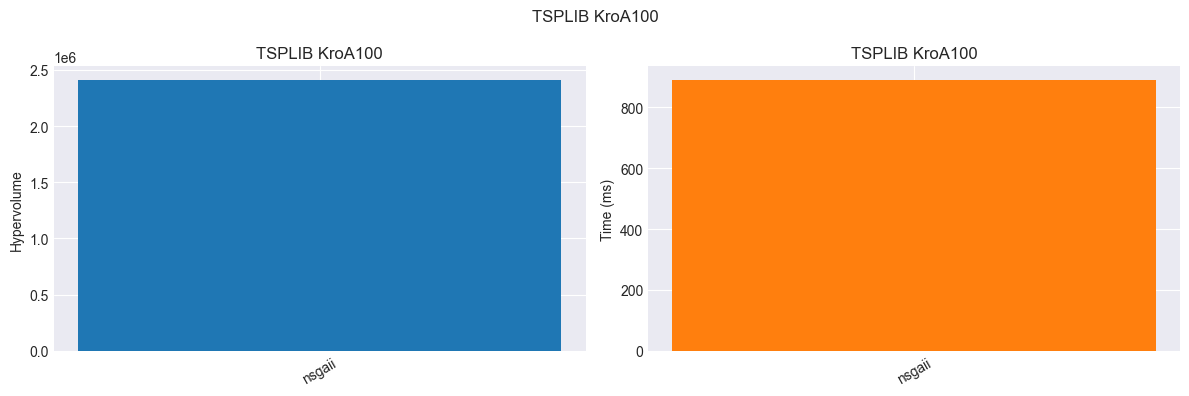

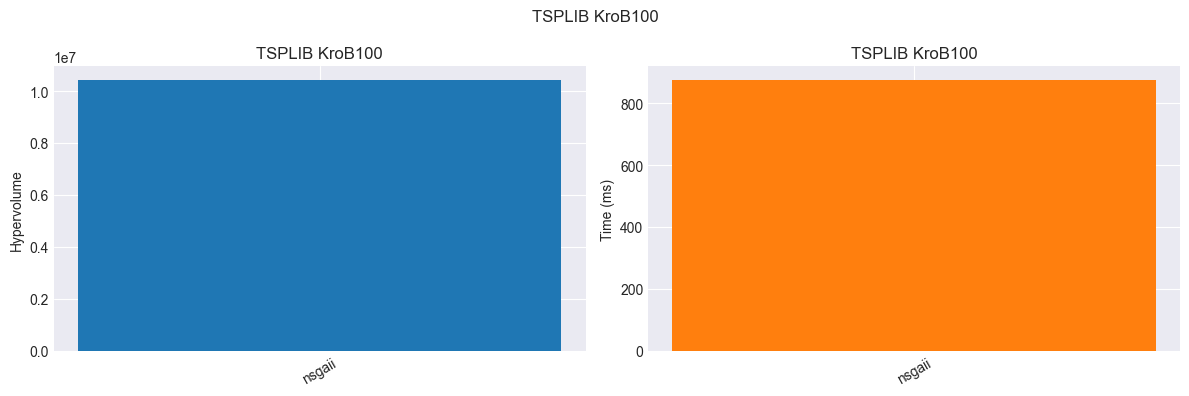

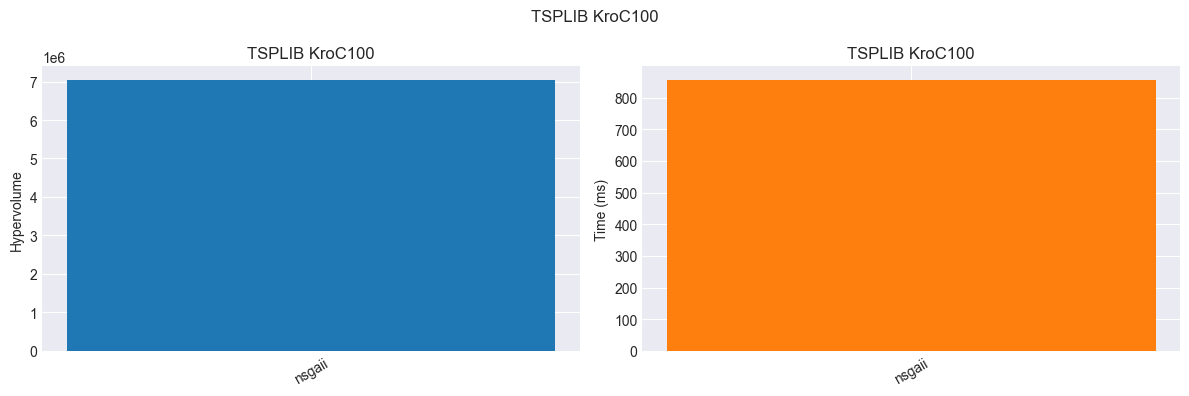

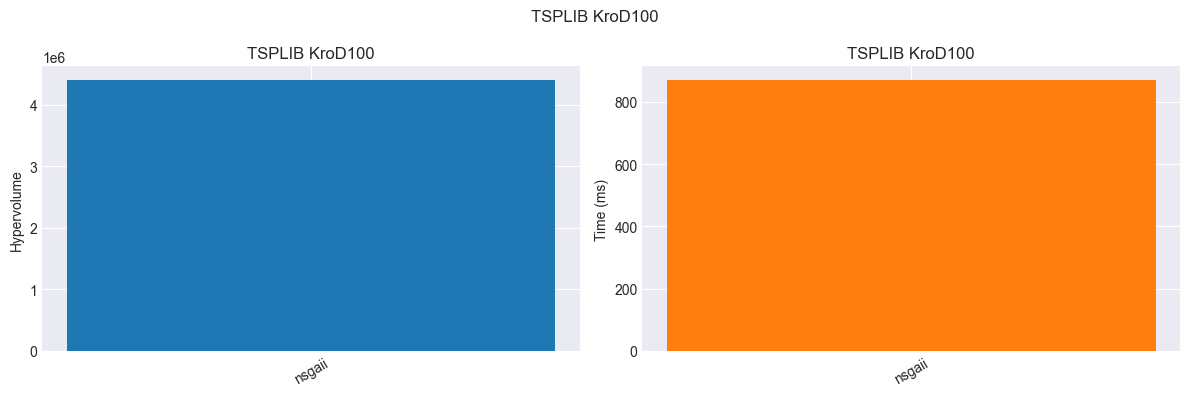

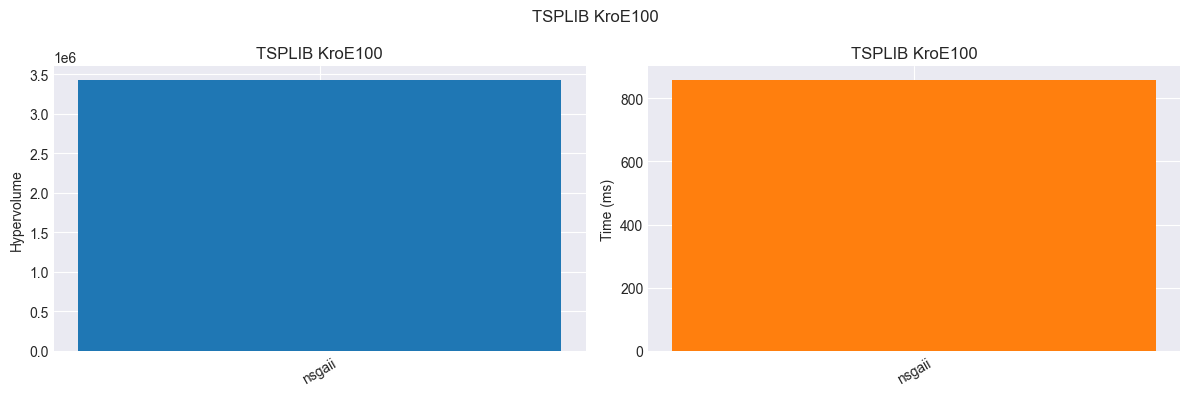

In [11]:

if summary_df.empty:
    print('No data yet.')
else:
    for label, group in summary_df.groupby('problem_label', sort=False):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].bar(group['algorithm'], group['hv'], color='tab:blue')
        axes[0].set_ylabel('Hypervolume')
        axes[0].set_title(label)
        axes[0].tick_params(axis='x', rotation=30)

        axes[1].bar(group['algorithm'], group['time_ms'], color='tab:orange')
        axes[1].set_ylabel('Time (ms)')
        axes[1].set_title(label)
        axes[1].tick_params(axis='x', rotation=30)

        fig.suptitle(label)
        fig.tight_layout()
        plt.show()


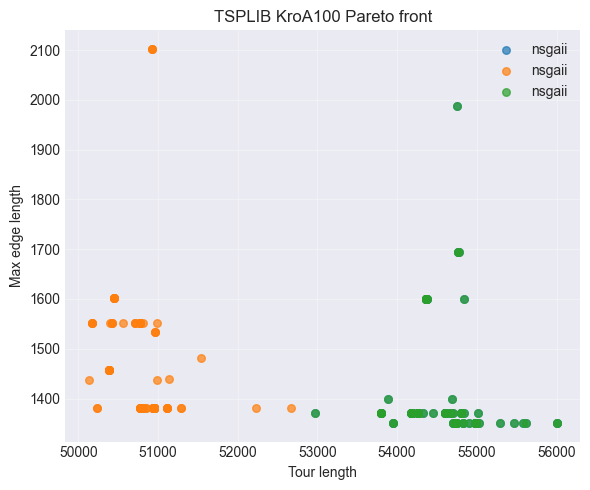

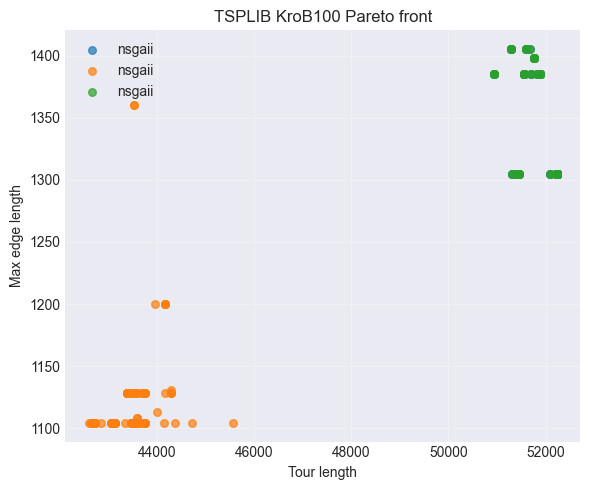

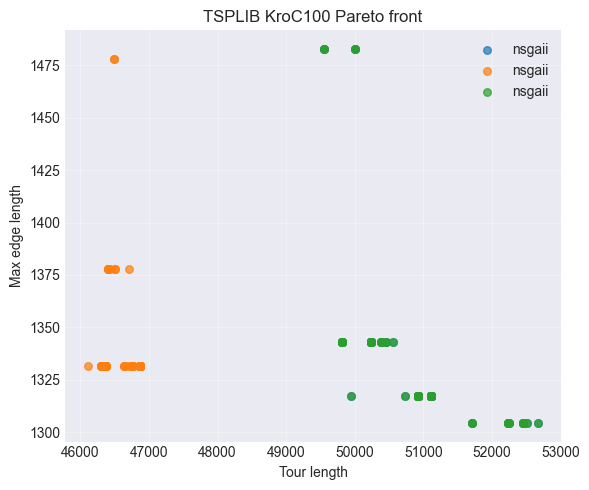

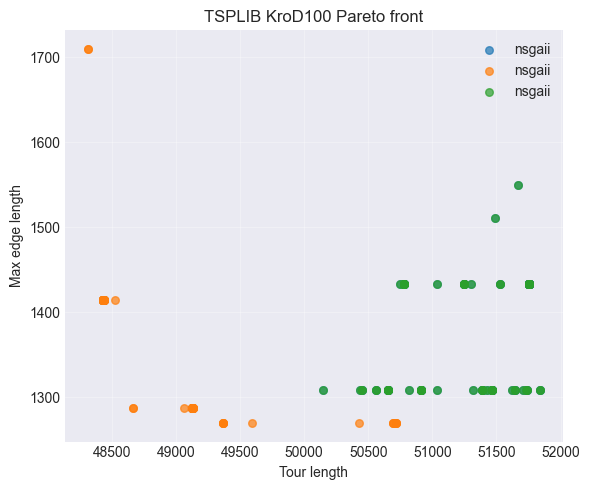

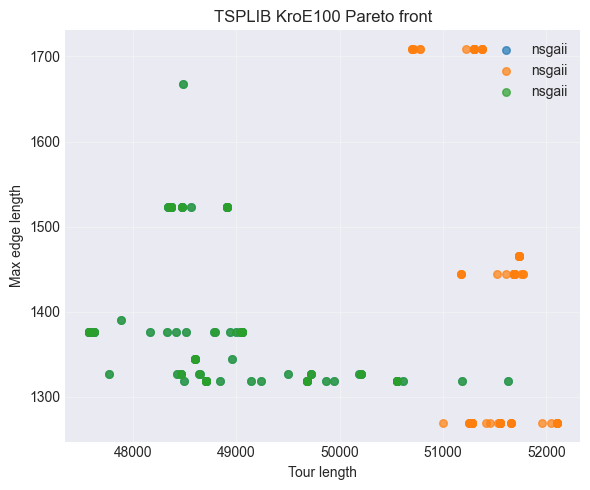

In [12]:

if not RUN_HISTORY:
    print('Run the experiment cell first.')
else:
    runs_by_problem = {}
    for res in RUN_HISTORY:
        label = res.selection.spec.label
        runs_by_problem.setdefault(label, []).append(res)
    for label, runs in runs_by_problem.items():
        fig, ax = plt.subplots(figsize=(6, 5))
        for res in runs:
            F = res.metrics['F']
            legend_entry = f"{res.metrics['algorithm']}"
            ax.scatter(F[:, 0], F[:, 1], s=30, alpha=0.7, label=legend_entry)
        ax.set_xlabel('Tour length')
        ax.set_ylabel('Max edge length')
        ax.set_title(f'{label} Pareto front')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
